## Inicjalizacja


In [359]:
from laptoppriceworkflow.data import get_json_data 
from laptoppriceworkflow.functions import clean_col_meta
from laptoppriceworkflow.functions import simplify_gwarancja
from laptoppriceworkflow.functions import simplify_komunikacja

import pandas as pd

import numpy as np

import seaborn as sns 

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import StandardScaler


In [360]:
df = get_json_data()

# Partycjonowanie
Preprocessing przygotowania modelu bedzie przeprowadzany tylko na czesci treningowej 
Pozniej przepuszcze przez niego czesc testowa, ktora swtorzylem oraz dodtkowy plik bez zmiennej celu

In [361]:
msk = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]

# Wstępna Analiza

In [362]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5923 entries, 70 to 5978
Data columns (total 17 columns):
buynow_price                         5923 non-null float64
rodzaj karty graficznej              5545 non-null object
komunikacja                          5325 non-null object
rozdzielczość (piksele)              5464 non-null object
liczba rdzeni procesora              5923 non-null object
wielkość pamięci ram                 5583 non-null object
system operacyjny                    5435 non-null object
typ dysku twardego                   5594 non-null object
sterowanie                           5413 non-null object
multimedia                           5386 non-null object
typ pamięci ram                      5265 non-null object
taktowanie bazowe procesora (ghz)    5215 non-null float64
seria procesora                      5519 non-null object
stan                                 5923 non-null object
pojemność dysku (gb)                 5553 non-null float64
gwarancja          

In [363]:
train.isnull().sum()/train.shape[0]

buynow_price                         0.000000
rodzaj karty graficznej              0.063819
komunikacja                          0.100962
rozdzielczość (piksele)              0.077495
liczba rdzeni procesora              0.000000
wielkość pamięci ram                 0.057403
system operacyjny                    0.082391
typ dysku twardego                   0.055546
sterowanie                           0.086105
multimedia                           0.090664
typ pamięci ram                      0.111092
taktowanie bazowe procesora (ghz)    0.119534
seria procesora                      0.068209
stan                                 0.000000
pojemność dysku (gb)                 0.062468
gwarancja                            0.000000
wielkość matrycy                     0.043559
dtype: float64

In [28]:
# Funkcja sprawdzajaca liczbe kategorii w kolumnie

for col_name in train.columns:
    if train[col_name].dtypes == 'object':
        unique_cat = len(train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories" .format(
            col_name =col_name, unique_cat = unique_cat))

Feature 'rodzaj karty graficznej' has 3 unique categories


TypeError: unhashable type: 'list'

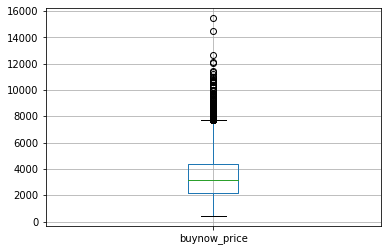

In [364]:
train.boxplot("buynow_price")

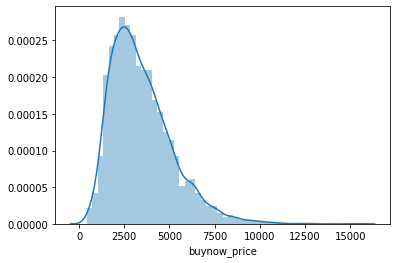

In [7]:
sns.distplot(train["buynow_price"])
plt.show()

# Budowa Preprocesingu

In [365]:
train_num = train[['buynow_price', 'taktowanie bazowe procesora (ghz)', 'pojemność dysku (gb)']]

imputer = SimpleImputer(strategy = 'median')
imputer.fit(df_num)
imputer.statistics_

X = imputer.transform(df_num)
df_num_imp = pd.DataFrame(X, columns=df_num.columns)


encoder = LabelEncoder()
#df_cat = df[["rodzaj karty graficznej", "komunikacja","rozdzielczość (piksele)"]]
df_cat = df["liczba rdzeni procesora"]
df_cat_encoded = encoder.fit_transform(df_cat)
df_cat_encoded

In [89]:
print(encoder.classes_)

['1' '2' '3' '4' '6' '8' 'nie dotyczy']


In [451]:
encoder = OneHotEncoder()
#df_cat_1hot = encoder.fit_transform(df_cat_encoded.reshape(-1,1))
df_cat_1hot = encoder.fit_transform(train[['gwarancja', 'rodzaj karty graficznej']])
df_cat_1hot

TypeError: argument must be a string or number

Lepsze gdy w kolumnie masz bardzo dużo kategorii i powstaje macierz rzadka (sparse matrix)
W innym przypadku lepiej LabelBinarizer() :)

In [243]:
type(df_cat_1hot)

scipy.sparse.csr.csr_matrix

In [180]:
#rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

buynow_price_ix, taktowanie_bazowe_procesora_ghz_ix, pojemność_dysku_gb_ix = 0, 1, 2

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_price_per_gb = True): # żadnych zmiennych *args ani **kargs
        self.add_price_per_gb = add_price_per_gb
    
    def fit(self, X, y=None):
        return self # nie robi nic innego
    
    def transform(self, X, y=None):
        price_per_ghz = X[:, taktowanie_bazowe_procesora_ghz_ix] / X[:, buynow_price_ix]
        #Populacja_na_rodzinę = X[:, population_ix] / X[:, household_ix]
        if self.add_price_per_gb:
            price_per_gb = X[:, pojemność_dysku_gb_ix] / X[:, buynow_price_ix]
            return np.c_[X, price_per_ghz, price_per_gb]
        else:
            return np.c_[X, price_per_ghz]

In [171]:
attr_adder = CombinedAttributesAdder(add_price_per_gb=True)
df_extra_attribs = attr_adder.transform(df.values)

In [206]:
type(df_extra_attribs)

numpy.ndarray

In [499]:
gwarancja_ix = 0

class CombinedAttributesAdder_cat(BaseEstimator, TransformerMixin):
                 
    def __init__(self, trans_gwarancja = True):
        self._trans_gwrancja = trans_gwarancja
    
    def fit(self, X, y = None):
        return self # nie robi nic innego
    
    def transform(self, X, y = None):
        if self._trans_gwrancja:
            gwarancja_trans = ['producenta' if x == 'producenta' else 'other' for x in X[:, gwarancja_ix]]
            X = np.delete(X, gwarancja_ix, 1)
            return np.c_[X, np.asarray(gwarancja_trans).reshape(-1,1)]
        else:
            return X

In [490]:
attr_adder_cat = CombinedAttributesAdder_cat()
df_extra_attribs_cat = attr_adder_cat.transform(train.values)

In [450]:
train[['gwarancja', 'rodzaj karty graficznej']].values

array([['sprzedawcy', 'grafika zintegrowana'],
       ['producenta', 'grafika dedykowana'],
       ['producenta', 'grafika zintegrowana'],
       ...,
       ['sprzedawcy', 'grafika dedykowana'],
       ['producenta', 'grafika dedykowana'],
       ['producenta', 'grafika dedykowana']], dtype=object)

In [410]:
df_extra_attribs_cat.shape

(5923, 18)

In [400]:
df_extra_attribs_cat

array([['other'],
       ['producenta'],
       ['producenta'],
       ...,
       ['other'],
       ['producenta'],
       ['producenta']], dtype='<U10')

In [389]:
type(df_extra_attribs_cat)

numpy.ndarray

In [381]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [503]:
num_attribs = list(train_num)
cat_attribs = list(["gwarancja","typ dysku twardego"])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('imputerr', SimpleImputer(missing_values=None, strategy="most_frequent")),
    ('cat_encoderr',CombinedAttributesAdder_cat()),
    ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [470]:
tt = num_pipeline.fit_transform(train)
ttt = cat_pipeline.fit_transform(train)

In [395]:
print(type(tt))
print(type(ttt))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [396]:
print(tt.shape)
print(ttt.shape)


(5923, 5)
(5923, 1)


In [293]:
print(tt)

[[-1.09861644 -1.24356384 -0.30878236  0.91743709  0.5912995 ]
 [-0.28558046 -0.97262095 -0.35190072 -0.39807241 -0.31369476]
 [-0.28558046 -0.70167807 -0.35190072 -0.31393579 -0.31369476]
 ...
 [-1.45867523  0.38209347 -1.31775218  4.36265098 -1.0688361 ]
 [-0.53762161 -0.1597923  -1.11078401  0.18176505 -0.96676405]
 [-0.31461746  0.11115059 -1.11078401 -0.02728925 -1.00528976]]


In [397]:
print(ttt)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [504]:
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [510]:
housing_prepared = full_pipeline.fit_transform(train)
housing_prepared[3]

array([-0.36691824, -0.96263086, -0.34443422, -0.31375416, -0.25835376,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ])

In [452]:
housing_prepared.shape

(5923, 11)

In [55]:
#pd.DataFrame(df_extra_attribs, columns=df_num.columns)
pd.DataFrame(df_extra_attribs, columns = df_num.columns.append(pd.Index(['price_per_ghz','4242'])))


,buynow_price,taktowanie bazowe procesora (ghz),pojemność dysku (gb),price_per_ghz,4242
0,1599.0,1.9,500.0,0.001188,0.312695
1,2999.0,2.0,480.0,0.000667,0.160053
2,2999.0,2.1,480.0,0.000700,0.160053
3,2849.0,2.0,480.0,0.000702,0.168480
4,2319.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
7848,1329.0,1.6,128.0,0.001204,0.096313
7849,979.0,NaN,32.0,NaN,0.032686
7850,2565.0,2.3,128.0,0.000897,0.049903
7851,4079.0,2.5,1128.0,0.000613,0.276538


In [5]:
train = clean_col_meta(train)

In [444]:
train.head(50)

,buynow_price,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy
70,1599.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.9,intel core i3,nowy,500.0,sprzedawcy,"13"" - 13.9"""
1489,2999.00,grafika dedykowana,"[nfc (near field communication), gps]",1920 x 1080,2,12 gb,[windows 10 home],None,[touchpad],"[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
407,2999.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,16 gb,[windows 7 professional 64-bit],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.1,intel pentium dual-core,nowy,480.0,producenta,"15"" - 15.9"""
1359,2849.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
3203,1302.91,grafika zintegrowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.5,intel celeron dual-core,nowy,128.0,sprzedawcy,"15"" - 15.9"""
7831,1699.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.6,intel pentium quad-core,nowy,120.0,producenta,"15"" - 15.9"""
4586,1769.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.7,intel core i3,nowy,256.0,sprzedawcy,"15"" - 15.9"""
7524,5043.00,grafika dedykowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr3,2.6,intel core i5,nowy,1000.0,producenta,"15"" - 15.9"""
10973,6519.00,grafika dedykowana,"[bluetooth, lan 10/100/1000 mbps, lan 10/100 m...",3840 x 2160,4,16 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura podświetlana]","[kamera, głośniki, mikrofon]",ddr4,2.8,intel core i7,nowy,240.0,producenta,"15"" - 15.9"""
1510,2677.00,grafika dedykowana,"[wi-fi 802.11 a/b/g/n/ac, bluetooth, lan 10/10...",1920 x 1080,2,12 gb,[brak systemu],ssd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.4,intel core i3,nowy,240.0,producenta,"15"" - 15.9"""


In [449]:
train['rodzaj karty graficznej'].value_counts()

grafika dedykowana      3272
grafika zintegrowana    2273
Name: rodzaj karty graficznej, dtype: int64

In [7]:
train["gwarancja"].value_counts()
grouped_gwarancja = train['buynow_price'].groupby(train["gwarancja"])
grouped_gwarancja.mean()

gwarancja
brak          2281.876667
producenta    3683.052892
sprzedawcy    2176.102213
Name: buynow_price, dtype: float64

In [31]:
train['gwarancja'].value_counts()

producenta    4965
sprzedawcy     901
brak             6
Name: gwarancja, dtype: int64

In [34]:
train['gwarancja'] = ['producenta' if x == 'producenta' else 'other' for x in train['gwarancja']]

AttributeError: 'list' object has no attribute 'value_counts'

In [455]:
train['typ dysku twardego'].value_counts()

ssd          2832
hdd          1754
ssd + hdd     870
emmc           73
hybrydowy      65
Name: typ dysku twardego, dtype: int64

In [ ]:
['producenta' if x == 'producenta' else 'other' for x in train['gwarancja']]

In [26]:
df.loc[df.gwarancja == 'brak', 'gwarancja'] = 'sprzedawcy'

In [19]:
df[df.gwarancja == 'brak']['gwarancja']

Series([], Name: gwarancja, dtype: object)

In [14]:
train =  simplify_gwarancja(train)

In [18]:
df.head(10)

,buynow_price,rodzaj_karty_graficznej,komunikacja,rozdzielczość_piksele,liczba_rdzeni_procesora,wielkość_pamięci_ram,system_operacyjny,typ_dysku_twardego,sterowanie,multimedia,typ_pamięci_ram,taktowanie_bazowe_procesora_ghz,seria_procesora,stan,pojemność_dysku_gb,gwarancja,wielkość_matrycy
70,1599.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.9,intel core i3,nowy,500.0,sprzedawcy,"13"" - 13.9"""
1359,2849.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
10567,2319.00,None,None,None,2,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None
3203,1302.91,grafika zintegrowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.5,intel celeron dual-core,nowy,128.0,sprzedawcy,"15"" - 15.9"""
7831,1699.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.6,intel pentium quad-core,nowy,120.0,producenta,"15"" - 15.9"""
7524,5043.00,grafika dedykowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr3,2.6,intel core i5,nowy,1000.0,producenta,"15"" - 15.9"""
10973,6519.00,grafika dedykowana,"[bluetooth, lan 10/100/1000 mbps, lan 10/100 m...",3840 x 2160,4,16 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura podświetlana]","[kamera, głośniki, mikrofon]",ddr4,2.8,intel core i7,nowy,240.0,producenta,"15"" - 15.9"""
1510,2677.00,grafika dedykowana,"[wi-fi 802.11 a/b/g/n/ac, bluetooth, lan 10/10...",1920 x 1080,2,12 gb,[brak systemu],ssd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.4,intel core i3,nowy,240.0,producenta,"15"" - 15.9"""
8158,2669.00,grafika dedykowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[brak systemu],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr3,2.6,intel core i5,nowy,480.0,producenta,"15"" - 15.9"""
11252,2799.00,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[brak systemu],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,256.0,producenta,"14"" - 14.9"""


In [ ]:
g = sns.FacetGrid(train, col="gwarancja_t", height=6)
g.map(sns.kdeplot, "buynow_price", shade=True)
sns.despine(left = True, bottom =True )
plt.show()

In [ ]:
##############################################################################
#### Komunikacja

train["komunikacja"].astype(str).value_counts()

In [ ]:
train["komunikacja"].isna().sum()

In [ ]:
train = simplify_komunikacja(train)

In [11]:
df["lan 10/100 mbps"] = (df["komunikacja"].str.contains('lan 10/100 mbps', regex=False)*1).sum()

In [12]:
df["lan 10/100/1000 mbps"] = (df["komunikacja"].str.contains('lan 10/100/1000 mbps', regex=False)*1).sum()

In [13]:
(df["komunikacja"].str.contains('nfc (near field communication)', regex=False)*1).sum()

1454

In [14]:
(df["komunikacja"].str.contains('modem 3g (wwan)', regex=False)*1).sum()

1009

In [15]:
(df["komunikacja"].str.contains('gps', regex=False)*1).sum()

269

In [16]:
(df["komunikacja"].str.contains('intel wireless display (widi)', regex=False)*1).sum()

1004

In [17]:
(df["komunikacja"].str.contains('modem 4g (lte)', regex=False)*1).sum()

267

In [18]:
(df["komunikacja"].str.contains('wi-fi 802.11 b/g/n', regex=False)*1).sum()

73

In [19]:
(df["komunikacja"].str.contains('wi-fi 802.11 b/g/n/ac', regex=False)*1).sum()

166

In [20]:
(df["komunikacja"].str.contains('wi-fi 802.11 a/b/g/n/ac', regex=False)*1).sum()

143

In [21]:
(df["komunikacja"].str.contains('wi-fi 802.11 a/b/g/n', regex=False)*1).sum()

17

In [22]:
df.shape

(7853, 20)

In [23]:
160/7853

0.020374379218133197

In [24]:
df.columns

Index(['buynow_price', 'rodzaj karty graficznej', 'komunikacja',
       'rozdzielczość (piksele)', 'liczba rdzeni procesora',
       'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
       'sterowanie', 'multimedia', 'typ pamięci ram',
       'taktowanie bazowe procesora (ghz)', 'seria procesora',
       'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy ', 'bluetooth',
       'wi-fi', 'lan 10/100 mbps', 'lan 10/100/1000 mbps'],
      dtype='object')

In [25]:
df.index

Int64Index([   70,  1489,   407,  1359, 10567,  3203,  7831,  4586,  7524,
            10973,
            ...
             6423,  7596, 11321, 11695,  6406, 10541,  8281,  8053,  8727,
             5978],
           dtype='int64', length=7853)

In [26]:
assert all(df.columns == ['buynow_price', 'rodzaj karty graficznej', 'komunikacja','rozdzielczość (piksele)', 'liczba rdzeni procesora',
        'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
        'sterowanie', 'multimedia', 'typ pamięci ram',
        'taktowanie bazowe procesora (ghz)', 'seria procesora',
        'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy ', 'bluetooth',
        'wi-fi', 'lan 10/100 mbps', 'lan 10/100/1000 mbps'])